In [1]:
pip install transformers

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForCausalLM
import torch
import textwrap

In [3]:
model_name = "felixoder/bug_detector_model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [4]:
bug_fixer_model = "felixoder/bug_fixer_model"
fixer_tokenizer = AutoTokenizer.from_pretrained(bug_fixer_model)
fixer_model = AutoModelForCausalLM.from_pretrained(bug_fixer_model, torch_dtype=torch.float16, device_map="auto")

tokenizer_config.json:   0%|          | 0.00/5.39k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [5]:
def classify_code(code):
    """Classify input code as 'buggy' or 'bug-free' using the trained model."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the correct device

    inputs = tokenizer(code, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    return "bug-free" if predicted_label == 0 else "buggy"




In [6]:
def fix_buggy_code(code):
    """Generate a fixed version of the buggy code using the bug fixer model."""
    prompt = f"### Fix this buggy Python code:\n{code} just give the fixed code nothing else\n### Fixed Python code:\n"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = fixer_tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = fixer_model.generate(
            **inputs,
            max_length=256,  # Reduce length for speed
            do_sample=False,  # Make it deterministic
            num_return_sequences=1  # Only one output
        )

    fixed_code = fixer_tokenizer.decode(outputs[0], skip_special_tokens=True)
    fixed_code = fixed_code.split("### Fixed Python code:")[1].strip() if "### Fixed Python code:" in fixed_code else fixed_code

    return textwrap.dedent(fixed_code).strip()


In [7]:
# Example buggy code input
code_input = """
for in nge(0, 9
  print(i)
if val > 12:
  print("val {val} is greater")
else:
  print("val {val} is less")
"""

# Classify the code using the fine-tuned model
status = classify_code(code_input)

if status == "buggy":
    print("Buggy Code Detected")
    fixed_code = fix_buggy_code(code_input)
    print("Fixed Code:")
    print(fixed_code)
else:
    print("Bug-free Code")

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Buggy Code Detected
Fixed Code:
```python
for i in range(0, 9):
    print(i)
if val > 12:
    print("val {} is greater".format(val))
else:
    print("val {} is less".format(val))
```


Accuracy: 80.00%
Precision: 1.00
Recall: 0.60
F1 Score: 0.75


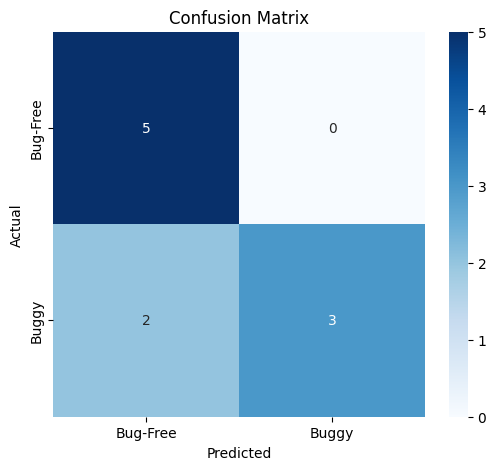

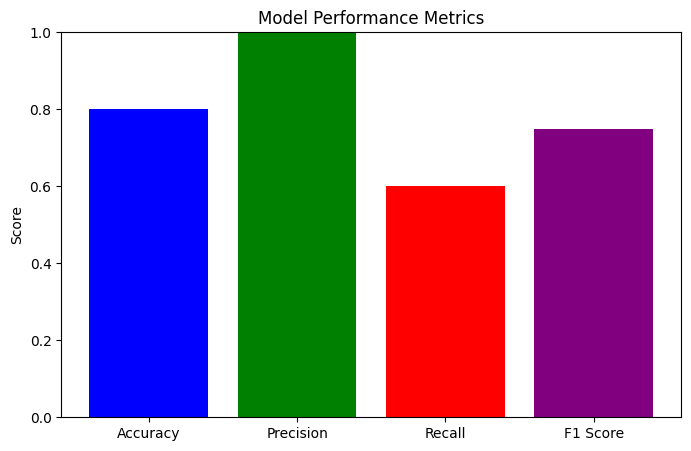

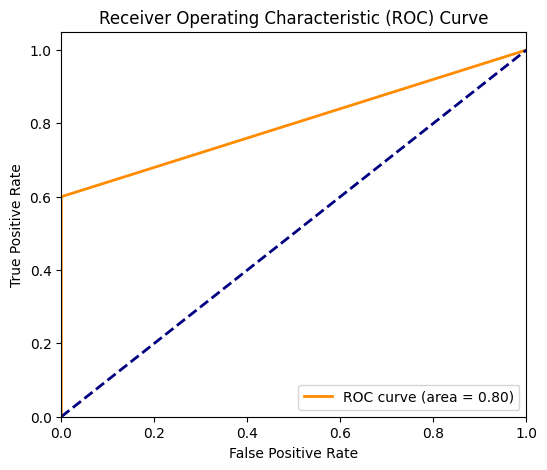

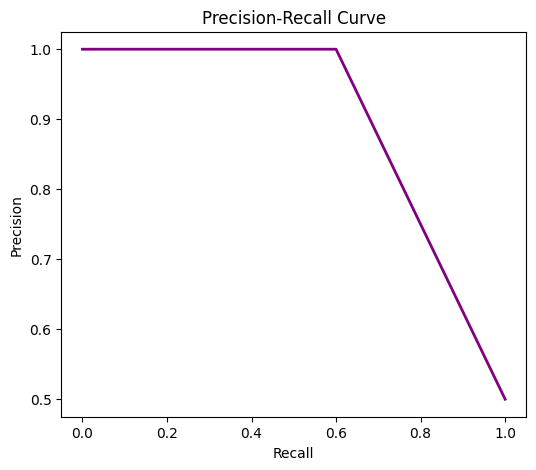

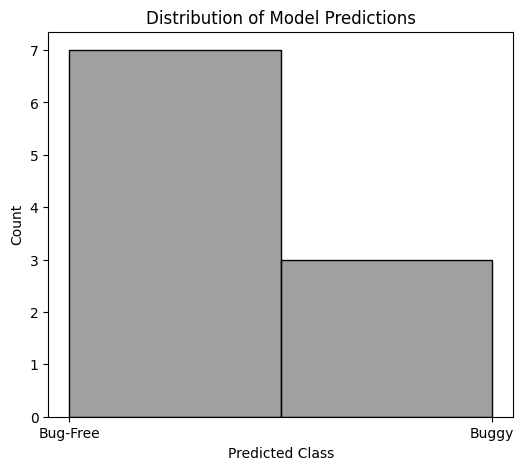

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

# Define test cases
test_cases = [
    ("for i in range(0, 9):\n  print(i)", 0),
    ("for in nge(0, 9\n  print(i)", 1),
    ("if val > 12:\n  print(f'val {val} is greater')", 0),
    ("if val > 12:\nprint('val {val} is greater')", 1),
    ("def add(a, b):\n  return a + b", 0),
    ("def add(a, b):\n  return a b", 1),
    ("print('Hello World!')", 0),
    ("pritn('Hello World!')", 1),
    ("a = [1, 2, 3]\nfor i in a:\n  print(i)", 0),
    ("a = [1, 2, 3]\nfor in a:\n  print(i)", 1),
]

# Ground truth labels
y_true = np.array([label for _, label in test_cases])

# Simulated model predictions (replace with actual classify_code function output)
y_pred = np.array([1 if classify_code(code) == "buggy" else 0 for code, _ in test_cases])

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print scores
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bug-Free", "Buggy"], yticklabels=["Bug-Free", "Buggy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Performance Metrics Bar Chart
metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=["blue", "green", "red", "purple"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Distribution of Model Predictions
plt.figure(figsize=(6, 5))
sns.histplot(y_pred, bins=2, kde=False, color='gray')
plt.xticks([0, 1], labels=["Bug-Free", "Buggy"])
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Distribution of Model Predictions")
plt.show()